### ① 데이터 연결하기
- 데이터가 있는 폴더를 연결합니다.
- arch를 설치합니다.

In [1]:
# 먼저 데이터가 저장된 폴더를 연결합시다.
!mkdir -p aiffel/time_series_basic 
# !ln -s data/* aiffel/time_series_basic
!cp data/AirPassengers.csv aiffel/time_series_basic/

cp: cannot stat 'data/AirPassengers.csv': No such file or directory


In [2]:
!pip install arch

  Using cached arch-5.3.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (907 kB)
  Using cached property_cached-1.6.4-py2.py3-none-any.whl (7.8 kB)


### ② ARIMA 실습해보기!
앞에서도 자주 만났던 AirPassengers 데이터셋을 SARIMA를 통해 예측해봅시다.

- 시계열 데이터 분석을 위한 라이브러리를 불러옵니다.
- AirPassengers 데이터셋을 불러옵니다.
- AirPassengers 데이터셋의 Month column을 제외합니다.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # acf plot 및 pacf plot을 그리기 위한 라이브러리
from statsmodels.tsa.arima_model import ARIMA # ARIMA 모델
import pmdarima as pm # Auto ARIMA 모델

In [4]:
ap = pd.read_csv('/aiffel/aiffel/time_series_basic/AirPassengers.csv')
ap.drop('Month', axis = 1, inplace = True)

### ③ 데이터 확인하기
- AirPassengers 데이터셋에서 Month가 제대로 제외되었는지 확인합니다.

In [5]:
ap

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


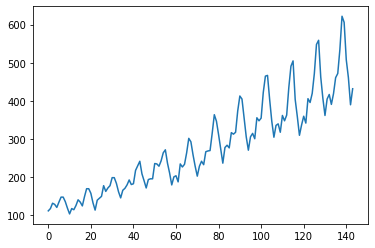

In [6]:
plt.plot(ap)
plt.show()

###  ④ 분산을 일정하게 만들기 - log transformation
- 로그변환(Log Transformation)을 통해 분산을 일정하게 조절합니다.
- 분산이 일정하게 적용되었는지 시각화한 후 확인합니다.

In [8]:
# np.log를 통해서 log transformation
ap_transformed = np.log(ap)
ap_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


[]

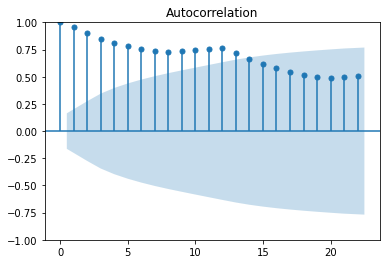

In [9]:
plot_acf(ap_transformed) # acf plot, 점차 감소하는 모양새를 지니고 있음
plt.plot()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


[]

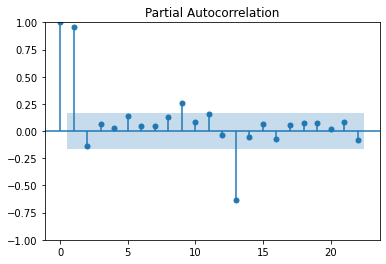

In [10]:
plot_pacf(ap_transformed) # pacf plot, lag 2까지 유의미한 결과를 보임
plt.plot()

### ⑤ 차분을 통해 분석하기
- ACF, PACF Plot과 차분을 활용하여 분석합니다.

In [11]:
ap_diff = ap_transformed.diff()
ap_diff = ap_diff.dropna()

[]

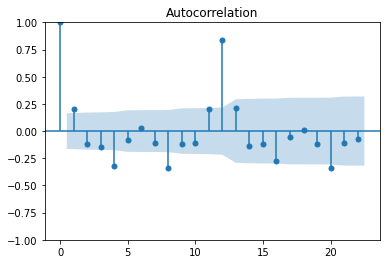

In [12]:
# lag 1과 lag 12에서 유의미한 lag가 포착됨
plot_acf(ap_diff)
plt.plot()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


[]

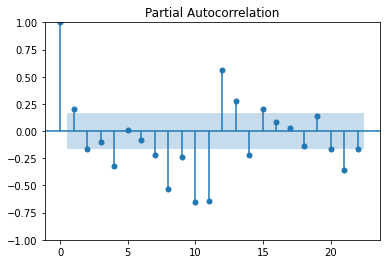

In [13]:
# lag 1, lag 8~12쯤에서 유의미한 lag가 포착됨
plot_pacf(ap_diff)
plt.plot()

acf와 pacf에서 n = 12 즈음에서 유의미한 상관관계가 나타납니다. 이는 계절성 성분으로 추측됩니다.

ARIMA를 적용할 때에 계절성 요인도 고려해야 합니다.

In [14]:
ap_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


In [15]:
train_size = int(len(ap_transformed)*0.8)

ap_transformed_train = ap_transformed[:train_size]
ap_transformed_test = ap_transformed[train_size:]

### ⑥ Auto ARIMA 적용 및 결과 확인
- AutoARIMA 내부 인자의 의미를 알아봅시다.
    - seasonal : False인 경우 non-seasonal model로 제한합니다.
    - suppress_warnings : ARIMA를 실행하면 생기는 에러문구를 나오지 않도록 해줍니다.
    - trace : True일 때 오류(error)가 발생하면 일부 내용을 출력합니다.
    - max_D : seasonal의 최대 값을 설정할 수 있습니다.

In [16]:
# AutoARIMA
# seasonal = True, max_D(계절차분) = 12
model = pm.AutoARIMA(seasonal = True, suppress_warnings = True, trace = True, max_D = 12) 
res = model.fit(ap_transformed_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-189.733, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-191.035, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-192.641, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189.957, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-196.702, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-196.895, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-196.569, Time=0.12 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 3.991 seconds


In [17]:
# confidence interval까지 도출
preds, conf_int = res.predict(n_periods=ap_transformed_test.shape[0], return_conf_int=True) 

# 아래의 코드 결과값을 서로 비교 분석해봅시다.
print(preds.shape) 
print(type(preds))
print('--'*40)
print(preds.shape[0])
print(type(preds.shape[0]))
# print('--'*40)
# print(preds)
# print('--'*40)
# print(conf_int)

(29,)
<class 'numpy.ndarray'>
--------------------------------------------------------------------------------
29
<class 'int'>


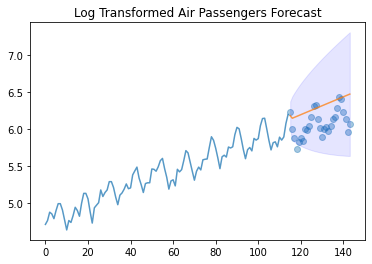

In [18]:
# 예측 성능을 시각화합니다. 
# 0. train과 test data를 축(axis)으로 만들었습니다.
# 1. x축은 test으로 만들어 놓은 train data를 사용하고, y축에 train data를 사용하여 train data를 시각화 합니다.
# 2. 1번 그래프에서 정답(AutoARIMA를 통해 만든 예측 값)에 해당하는 일자형 그래프가 생성됩니다.
# 3. 원래 가지고 있던 데이터셋의 y값(지도 학습의 정답)을 산점도(scatter plot)로 생성합니다.
# 4. 2, 3번의 분포에 해당하는 구간을 채워 그래프로 나타냈습니다.
x_axis = np.arange(ap_transformed_train.shape[0] + preds.shape[0]) # 115 + 29, plot을 그리기 위해 x축을 생성합니다. # 0
plt.plot(x_axis[:ap_transformed_train.shape[0]],ap_transformed_train, alpha=0.75) # 1
plt.plot(x_axis[ap_transformed_train.shape[0]:], preds, alpha=0.75) # 2
plt.scatter(x_axis[ap_transformed_train.shape[0]:],ap_transformed_test, 
            alpha=0.4, marker='o')  # 3 기존 test data는 scatter
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b') # 4
plt.title("Log Transformed Air Passengers Forecast") # plot의 제목
plt.show() # 4개의 plot을 시각화 합니다.

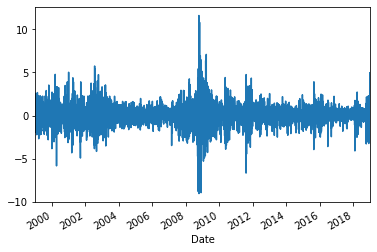

In [19]:
# ⑦-1 : 데이터 및 라이브러리 불러오기 
import datetime as dt # 날짜와 시간을 조작할 수 있는 Python 라이브러리 입니다 .
import arch.data.sp500 # S&P 500 데이터셋을 arch에서 불러옵니다.

# ⑦-2 : 필요한 데이터로 가공하고 시각화를 통해 확인하기
st = dt.datetime(2002, 1, 1) # start date
en = dt.datetime(2022, 1, 1) # end date
data = arch.data.sp500.load() # s&p 500 데이터 불러오기
market = data["Adj Close"] # 종가만 활용
returns = 100 * market.pct_change().dropna() # return값으로 변환
ax = returns.plot() # 수익률을 그래프로 만들기
xlim = ax.set_xlim(returns.index.min(), returns.index.max()) # xlim은 x축 값의 보기를 제한 합니다. 
plt.show()

In [20]:
# ⑦-3 : ARCH 모델 적용
from arch import arch_model

am = arch_model(returns) # return을 arch모델에 적합
res = am.fit(update_freq=5)

# ⑦-4 : 지표를 통한 결과 확인
print(res.summary())
# 다양한 결과가 제시되어있으나, 수업때 배웠던 p-value, AIC, BIC위주로 내용을 파악
# 아래에 있는 volatility model을 보면 alpha[1], Beta[1]은 GARCH(1,1)을 의미하며, p-value를 통해 신뢰도 95%에서 이들이 유의미함을 도출

Iteration:      5,   Func. Count:     35,   Neg. LLF: 6970.2765831170655
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6936.718477482658
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6936.718476988985
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6936.72
Distribution:                  Normal   AIC:                           13881.4
Method:            Maximum Likelihood   BIC:                           13907.5
                                        No. Observations:                 5030
Date:                Wed, Apr 12 2023   Df Residuals:                     5029
Time:         

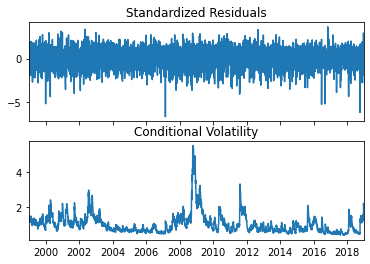

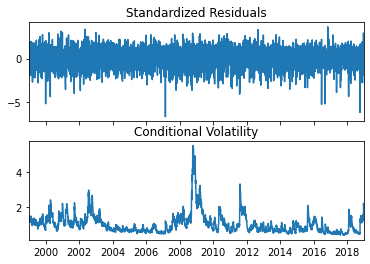

In [21]:
# ⑦-5 : 시각화를 통한 결과값 확인
res.plot()